In [1]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
import os

import numpy as np

from PIL import Image
import glob
import time
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset 

### Data Loader
#### - Loading Data (ImageNet, cifar-10, etc not MNIST)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
datamode = 1
if datamode == 0:
    datapath = './data/MNIST'
elif datamode ==1:
    datapath = './data/cifar10'

In [38]:
# Set Data path
# datapath = './data/cifar10'
os.makedirs(datapath, exist_ok=True)

# Pre-process
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    transforms.Grayscale(1)
])

# Laod MNIST
train_dataset = datasets.CIFAR10(datapath, train=True, download=True, transform=transform)


Files already downloaded and verified


In [39]:
img, label = train_dataset.data, train_dataset.targets
'''
print('img.shape:', img.shape)
print('label.shape:', label.shape)

# Make it to 4D Tensor
# 기존 : (#Batch) x (height) x (width) -> (#Batch) x (#channel) x (height) x(width)
if len(img.shape) == 3:
    img = img.unsqueeze(1)
print('Unsqueezed img.shape:', img.shape)

# Visualize
img_grid = utils.make_grid(img[:40], ncol=8, padding=2)
def show(img):
    img = img.numpy() # Tensor -> numpy array
    img = img.transpose([1,2,0]) # C x H x W -> H x W x C
    plt.imshow(img, interpolation='nearest')
show(img_grid)
'''

"\nprint('img.shape:', img.shape)\nprint('label.shape:', label.shape)\n\n# Make it to 4D Tensor\n# 기존 : (#Batch) x (height) x (width) -> (#Batch) x (#channel) x (height) x(width)\nif len(img.shape) == 3:\n    img = img.unsqueeze(1)\nprint('Unsqueezed img.shape:', img.shape)\n\n# Visualize\nimg_grid = utils.make_grid(img[:40], ncol=8, padding=2)\ndef show(img):\n    img = img.numpy() # Tensor -> numpy array\n    img = img.transpose([1,2,0]) # C x H x W -> H x W x C\n    plt.imshow(img, interpolation='nearest')\nshow(img_grid)\n"

In [40]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(datapath, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


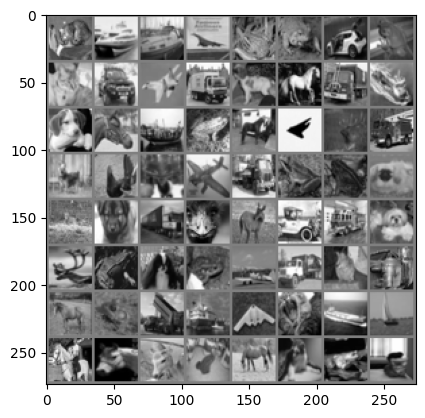

cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [42]:
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(len(train_loader))

782


In [43]:
# set parameters
params = {
    'num_classes':10,
    'nz':100,
    'input_size':(1,32,32)
}

In [44]:
class Generator(nn.Module):
    
    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes']
        self.nz = params['nz'] # 노이즈 수
        self.input_size = params['input_size'] # (1,28,28
        
        # Noise와 label을 결합하는 용도인 label embedding matrix를 생성
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)
        
        # Generator
        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,int(np.prod(self.input_size))),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        # noise와 label의 결합
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x
    
# check
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator(params).to(device)
out_gen = model_gen(x,label) # 가짜 이미지 생성
print(out_gen.shape)

torch.Size([16, 1, 32, 32])


In [54]:
class Discriminator(nn.Module):
    
     def __init__(self, params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
     def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)
        x = self.dis(dis_input)
        return x
    
# check
x = torch.randn(16,1,32,32,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([16, 1])


In [46]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [47]:
# 손실 함수
loss_func = nn.BCELoss() 

from torch import optim

lr = 1e-6
beta1 = 0.5
beta2 = 0.999

# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1,beta2)) # Discrminator
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1,beta2)) # Generator

# 학습 파라미터
nz = params['nz'] # Noise vector initialize
num_epochs = 20000

loss_history={'gen':[],
              'dis':[]}

In [48]:
# Train
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_loader:
        ba_si = xb.shape[0]
        
        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device) # fake_label
        
        # Genetator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

         # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()
        
        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label)
        loss_fake = loss_func(out_dis,yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 0.678024, D_Loss: 0.683271, time: 0.20 min
Epoch: 2, G_Loss: 0.668198, D_Loss: 0.666142, time: 0.39 min
Epoch: 3, G_Loss: 0.592322, D_Loss: 0.689975, time: 0.59 min
Epoch: 5, G_Loss: 0.657193, D_Loss: 0.697300, time: 0.79 min
Epoch: 6, G_Loss: 0.683829, D_Loss: 0.686202, time: 0.99 min
Epoch: 7, G_Loss: 0.676604, D_Loss: 0.668012, time: 1.19 min
Epoch: 8, G_Loss: 0.636779, D_Loss: 0.671040, time: 1.39 min
Epoch: 10, G_Loss: 0.619026, D_Loss: 0.684668, time: 1.58 min
Epoch: 11, G_Loss: 0.660814, D_Loss: 0.697089, time: 1.78 min
Epoch: 12, G_Loss: 0.701396, D_Loss: 0.692686, time: 1.98 min
Epoch: 14, G_Loss: 0.687908, D_Loss: 0.686356, time: 2.18 min
Epoch: 15, G_Loss: 0.686926, D_Loss: 0.676976, time: 2.37 min
Epoch: 16, G_Loss: 0.655029, D_Loss: 0.697005, time: 2.56 min
Epoch: 17, G_Loss: 0.678694, D_Loss: 0.694971, time: 2.76 min
Epoch: 19, G_Loss: 0.681909, D_Loss: 0.699557, time: 2.96 min
Epoch: 20, G_Loss: 0.714038, D_Loss: 0.686888, time: 3.16 min
Epoch: 21, G_Lo

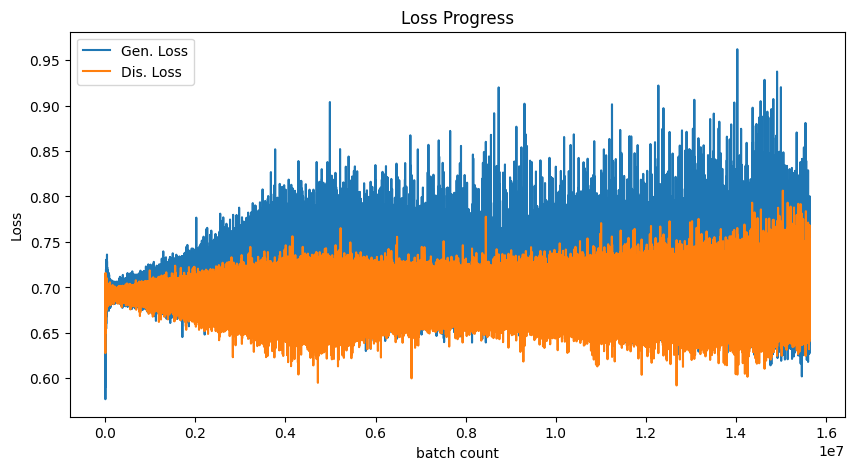

In [49]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

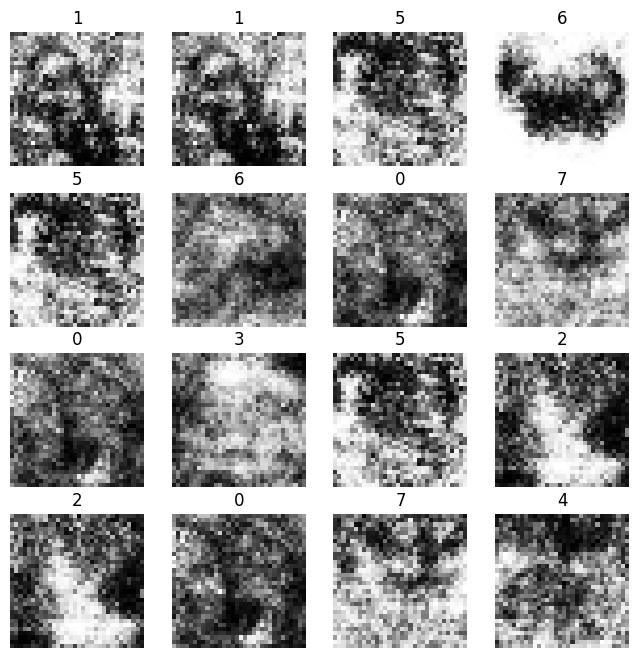

In [51]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fig = plt.figure(figsize=(8,8))
    cols, rows = 4, 4 # row와 col 갯수
    for i in range(rows * cols):
        fixed_noise = torch.randn(16, 100, device=device)
        label = torch.randint(0,9,(16,), device=device)
        img_fake = model_gen(fixed_noise, label).detach().cpu()
        fig.add_subplot(rows, cols, i+1)
        plt.title(label[i].item())
        plt.axis('off')
        plt.imshow(img_fake[i].squeeze(), cmap='gray')
plt.show()

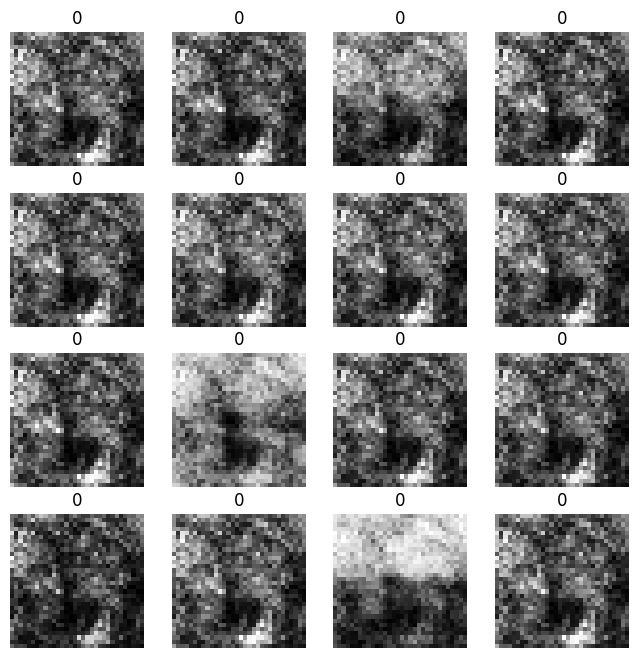

In [52]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fig = plt.figure(figsize=(8,8))
    cols, rows = 4, 4 # row와 col 갯수
    for i in range(rows * cols):
        fixed_noise = torch.randn(16, 100, device=device)
        label = torch.randint(0,1,(16,), device=device)
        img_fake = model_gen(fixed_noise, label).detach().cpu()
        fig.add_subplot(rows, cols, i+1)
        plt.title(label[i].item())
        plt.axis('off')
        plt.imshow(img_fake[i].squeeze(), cmap='gray')
plt.show()

In [53]:
'''
0 gyaetongdo
1 pyeongmyundo
2 goosungdo
3 gigibaechido
4 Legends
5 layout
6 cable_wiring_diagram
7 Seonbunjang
8 poseoldo
9 sangsaedo
10 gaehwangdo
11 wiichido
12 domyunmokcha
13 gujomooldo
14 ganji
15 jickseondo
'''

'\n0 gyaetongdo\n1 pyeongmyundo\n2 goosungdo\n3 gigibaechido\n4 Legends\n5 layout\n6 cable_wiring_diagram\n7 Seonbunjang\n8 poseoldo\n9 sangsaedo\n10 gaehwangdo\n11 wiichido\n12 domyunmokcha\n13 gujomooldo\n14 ganji\n15 jickseondo\n'